<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego colab a google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
import os

def conta_file(directory):
    try:

        elementi = os.listdir(directory)

        file = [f for f in elementi if os.path.isfile(os.path.join(directory, f))]

        numero_file = len(file)
        return numero_file
    except Exception as e:
        print(f"Errore: {e}")
        return 0

directory_path = '/content/Labels'
print(f"Numero di file nella directory: {conta_file(directory_path)}")


Numero di file nella directory: 3401


Importo le librerie necessarie

In [2]:
!pip install rasterio

In [3]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show
import torch.nn as nn
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import torchvision
from osgeo import gdal
import cv2
import tifffile as tiff
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

Definisco alcune directory

In [4]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

Media e std calcolate in Funzioni.ipynb

In [5]:
# mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
# std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
mean = [0.0, 0.0, 0.0, 0.0]
std = [1.0, 1.0, 1.0, 1.0]

Definiamo la classe SARDataset

In [37]:
# class SARDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, transform=None):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]


#         with rasterio.open(image_path) as src:
#             image = src.read().transpose((1, 2, 0))
#             # print(image.shape)
#             image = image.astype(np.float32)

#         with rasterio.open(mask_path) as src:
#             mask = src.read(1).astype(np.float32)
#             # print(mask.shape)
#             mask[mask == 255.0] = 1.0


#         if self.transform is not None:
#             augmentations = self.transform(image=image, mask=mask)
#             image = augmentations["image"]
#             mask = augmentations["mask"]

#         return image, mask

class SARDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            image = image.astype(np.float32)

            mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
            std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
            image = (image - mean) / std

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

Carico i percorsi delle immagini per il training, il validation e il test set

In [7]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]
train_label_paths = ['/' + line[1] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]
val_label_paths = ['/' + line[1] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]
test_label_paths = ['/' + line[1] for line in test_data]

Creo il modello UNET

Classe DoubleConv

In [8]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)



Classe UNET

In [9]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

Seed

In [10]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

Funzione per il training

In [11]:
def train_fn(loader, model, optimizer, loss_fn, scaler, txtfile):
    loop = tqdm(loader)
    tot_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.float().to(device=device)

        with torch.cuda.amp.autocast():
            predictions = model(data).squeeze(1)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tot_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = tot_loss / len(loader)
    with open(txtfile, "a") as f:
        f.write(f"Train Loss: {avg_loss:.4f}\n")


Utils

In [12]:
def save_checkpoint(state, filename="/content/drive/MyDrive/model1/checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

Evaluation function

In [13]:
def eval_fn(loader, model, loss_fn, txtfile, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    total_dice_score = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_loss = 0

    with torch.no_grad():
        for num_it, (x, y) in enumerate(loader, start=1):
            print(num_it)
            x = x.to(device)
            y = y.to(device)
            out = model(x).squeeze(1)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            preds = torch.sigmoid(out)
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            dice_score = (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            total_dice_score += dice_score.item()

            y_np = y.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            total_precision += precision_score(y_np, preds_np, zero_division=1)
            total_recall += recall_score(y_np, preds_np, zero_division=1)
            total_f1 += f1_score(y_np, preds_np, zero_division=1)

    avg_loss = total_loss / len(loader)
    avg_dice_score = total_dice_score / len(loader)
    avg_precision = total_precision / len(loader)
    avg_recall = total_recall / len(loader)
    avg_f1 = total_f1 / len(loader)
    accuracy = num_correct / num_pixels * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Dice score: {avg_dice_score:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    with open(txtfile, "a") as f:
        f.write(f"Validation Loss: {avg_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Dice score: {avg_dice_score:.4f}\n")
        f.write(f"Precision: {avg_precision:.4f}\n")
        f.write(f"Recall: {avg_recall:.4f}\n")
        f.write(f"F1 Score: {avg_f1:.4f}\n")
        f.write("\n")

    model.train()
    return avg_loss, accuracy, avg_dice_score, avg_precision, avg_recall, avg_f1

In [14]:
def save_predictions_as_imgs(loader, model, folder, device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    it = 1
    for idx, (x, y) in enumerate(tqdm(loader, desc="Saving predictions")):
        print(it)
        it += 1
        x = x.to(device=device)
        y = y.to(device=device).unsqueeze(1)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        combined = torch.cat((y, preds), dim=2)
        torchvision.utils.save_image(combined, f"{folder}/comparison_{idx}.png")

    model.train()


Training baseline

In [26]:
set_seed(42)

transform = A.Compose([
    A.Resize(height=320, width=320),
    # A.CenterCrop(height=896, width=896),
    # A.RandomCrop(height=320, width=320),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=1),
    # A.Rotate(limit=90, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=320, width=320),
    # A.CenterCrop(height=896, width=896),
    # A.RandomCrop(height=320, width=320),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.Rotate(limit=90, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

train_dataset = SARDataset(train_image_paths, train_label_paths, transform=transform)
val_dataset = SARDataset(val_image_paths, val_label_paths, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
load_model = True
lr = 1e-5
model_dir = "/content/drive/MyDrive/model13"
step_size = 18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size)
num_epochs = 20
scaler = torch.cuda.amp.GradScaler()

if load_model:
  load_checkpoint(torch.load(model_dir + "/checkpoint.pth.tar"), model)



=> Loading checkpoint


In [16]:
best_f1_score = 0.0

In [24]:
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    train_fn(train_loader, model, optimizer, criterion, scaler, model_dir + "/output/output.txt")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, model_dir + "/checkpoint.pth.tar")

    val_loss, val_accuracy, val_dice_score, val_precision, val_recall, val_f1 = eval_fn(val_loader, model, criterion, model_dir + "/output/output.txt", device=device)

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        save_checkpoint(checkpoint, filename=os.path.join(model_dir, "best_model.pth.tar"))
        print(f"New best F1 score: {best_f1_score:.4f}")

    if (epoch + 1) % 5 == 0:
        save_predictions_as_imgs(val_loader, model, model_dir + "/images/", device=device)

    scheduler.step()


epoch 0


100%|██████████| 298/298 [03:07<00:00,  1.59it/s, loss=0.0691]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0762
Accuracy: 97.00
Dice score: 0.7637
Precision: 0.8458
Recall: 0.6983
F1 Score: 0.7637
epoch 1


100%|██████████| 298/298 [03:29<00:00,  1.42it/s, loss=0.0139]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0756
Accuracy: 97.03
Dice score: 0.7684
Precision: 0.8403
Recall: 0.7100
F1 Score: 0.7684
=> Saving checkpoint
New best F1 score: 0.7684
epoch 2


100%|██████████| 298/298 [03:00<00:00,  1.65it/s, loss=0.0267]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0746
Accuracy: 97.05
Dice score: 0.7704
Precision: 0.8398
Recall: 0.7132
F1 Score: 0.7704
=> Saving checkpoint
New best F1 score: 0.7704
epoch 3


100%|██████████| 298/298 [03:07<00:00,  1.59it/s, loss=0.0517]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0746
Accuracy: 97.07
Dice score: 0.7711
Precision: 0.8436
Recall: 0.7118
F1 Score: 0.7711
=> Saving checkpoint
New best F1 score: 0.7711
epoch 4


100%|██████████| 298/298 [03:03<00:00,  1.63it/s, loss=0.0495]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0739
Accuracy: 97.09
Dice score: 0.7723
Precision: 0.8439
Recall: 0.7139
F1 Score: 0.7723
=> Saving checkpoint
New best F1 score: 0.7723


Saving predictions:   0%|          | 0/85 [00:00<?, ?it/s]

1


Saving predictions:   1%|          | 1/85 [00:06<09:26,  6.74s/it]

2


Saving predictions:   2%|▏         | 2/85 [00:07<04:15,  3.08s/it]

3


Saving predictions:   4%|▎         | 3/85 [00:07<02:39,  1.94s/it]

4


Saving predictions:   5%|▍         | 4/85 [00:08<01:50,  1.36s/it]

5


Saving predictions:   6%|▌         | 5/85 [00:11<02:55,  2.19s/it]

6


Saving predictions:   7%|▋         | 6/85 [00:12<02:07,  1.62s/it]

7


Saving predictions:   8%|▊         | 7/85 [00:12<01:37,  1.26s/it]

8


Saving predictions:   9%|▉         | 8/85 [00:13<01:17,  1.00s/it]

9


Saving predictions:  11%|█         | 9/85 [00:15<01:35,  1.26s/it]

10


Saving predictions:  12%|█▏        | 10/85 [00:15<01:17,  1.03s/it]

11


Saving predictions:  13%|█▎        | 11/85 [00:16<01:04,  1.14it/s]

12


Saving predictions:  14%|█▍        | 12/85 [00:16<00:53,  1.36it/s]

13


Saving predictions:  15%|█▌        | 13/85 [00:18<01:08,  1.04it/s]

14


Saving predictions:  16%|█▋        | 14/85 [00:18<00:57,  1.22it/s]

15


Saving predictions:  18%|█▊        | 15/85 [00:19<00:47,  1.46it/s]

16


Saving predictions:  19%|█▉        | 16/85 [00:19<00:41,  1.68it/s]

17


Saving predictions:  20%|██        | 17/85 [00:20<00:56,  1.21it/s]

18


Saving predictions:  21%|██        | 18/85 [00:21<00:58,  1.15it/s]

19


Saving predictions:  22%|██▏       | 19/85 [00:22<00:47,  1.38it/s]

20


Saving predictions:  24%|██▎       | 20/85 [00:22<00:46,  1.39it/s]

21


Saving predictions:  25%|██▍       | 21/85 [00:25<01:25,  1.34s/it]

22


Saving predictions:  26%|██▌       | 22/85 [00:26<01:06,  1.05s/it]

23


Saving predictions:  27%|██▋       | 23/85 [00:26<00:52,  1.18it/s]

24


Saving predictions:  28%|██▊       | 24/85 [00:27<00:53,  1.14it/s]

25


Saving predictions:  29%|██▉       | 25/85 [00:30<01:30,  1.50s/it]

26


Saving predictions:  31%|███       | 26/85 [00:30<01:09,  1.17s/it]

27


Saving predictions:  32%|███▏      | 27/85 [00:31<00:54,  1.07it/s]

28


Saving predictions:  33%|███▎      | 28/85 [00:31<00:50,  1.13it/s]

29


Saving predictions:  34%|███▍      | 29/85 [00:34<01:19,  1.42s/it]

30


Saving predictions:  35%|███▌      | 30/85 [00:34<01:01,  1.11s/it]

31


Saving predictions:  36%|███▋      | 31/85 [00:35<00:48,  1.12it/s]

32


Saving predictions:  38%|███▊      | 32/85 [00:36<00:46,  1.13it/s]

33


Saving predictions:  39%|███▉      | 33/85 [00:38<01:15,  1.45s/it]

34


Saving predictions:  40%|████      | 34/85 [00:39<00:57,  1.14s/it]

35


Saving predictions:  41%|████      | 35/85 [00:39<00:46,  1.08it/s]

36


Saving predictions:  42%|████▏     | 36/85 [00:40<00:45,  1.08it/s]

37


Saving predictions:  44%|████▎     | 37/85 [00:43<01:18,  1.63s/it]

38


Saving predictions:  45%|████▍     | 38/85 [00:44<00:59,  1.26s/it]

39


Saving predictions:  46%|████▌     | 39/85 [00:44<00:45,  1.00it/s]

40


Saving predictions:  47%|████▋     | 40/85 [00:45<00:44,  1.01it/s]

41


Saving predictions:  48%|████▊     | 41/85 [00:49<01:15,  1.72s/it]

42


Saving predictions:  49%|████▉     | 42/85 [00:49<00:56,  1.31s/it]

43


Saving predictions:  51%|█████     | 43/85 [00:49<00:43,  1.03s/it]

44


Saving predictions:  52%|█████▏    | 44/85 [00:51<00:44,  1.09s/it]

45


Saving predictions:  53%|█████▎    | 45/85 [00:55<01:24,  2.11s/it]

46


Saving predictions:  54%|█████▍    | 46/85 [00:56<01:03,  1.64s/it]

47


Saving predictions:  55%|█████▌    | 47/85 [00:56<00:48,  1.28s/it]

48


Saving predictions:  56%|█████▋    | 48/85 [00:57<00:42,  1.16s/it]

49


Saving predictions:  58%|█████▊    | 49/85 [01:02<01:20,  2.24s/it]

50


Saving predictions:  59%|█████▉    | 50/85 [01:02<01:00,  1.72s/it]

51


Saving predictions:  60%|██████    | 51/85 [01:03<00:46,  1.38s/it]

52


Saving predictions:  61%|██████    | 52/85 [01:03<00:38,  1.16s/it]

53


Saving predictions:  62%|██████▏   | 53/85 [01:08<01:05,  2.05s/it]

54


Saving predictions:  64%|██████▎   | 54/85 [01:08<00:48,  1.57s/it]

55


Saving predictions:  65%|██████▍   | 55/85 [01:08<00:36,  1.22s/it]

56


Saving predictions:  66%|██████▌   | 56/85 [01:10<00:38,  1.33s/it]

57


Saving predictions:  67%|██████▋   | 57/85 [01:14<01:02,  2.22s/it]

58


Saving predictions:  68%|██████▊   | 58/85 [01:15<00:45,  1.67s/it]

59


Saving predictions:  69%|██████▉   | 59/85 [01:15<00:33,  1.31s/it]

60


Saving predictions:  71%|███████   | 60/85 [01:16<00:27,  1.09s/it]

61


Saving predictions:  72%|███████▏  | 61/85 [01:21<00:54,  2.28s/it]

62


Saving predictions:  73%|███████▎  | 62/85 [01:21<00:39,  1.71s/it]

63


Saving predictions:  74%|███████▍  | 63/85 [01:22<00:28,  1.32s/it]

64


Saving predictions:  75%|███████▌  | 64/85 [01:22<00:23,  1.11s/it]

65


Saving predictions:  76%|███████▋  | 65/85 [01:26<00:40,  2.04s/it]

66


Saving predictions:  78%|███████▊  | 66/85 [01:27<00:29,  1.55s/it]

67


Saving predictions:  79%|███████▉  | 67/85 [01:27<00:21,  1.21s/it]

68


Saving predictions:  80%|████████  | 68/85 [01:28<00:16,  1.04it/s]

69


Saving predictions:  81%|████████  | 69/85 [01:30<00:23,  1.49s/it]

70


Saving predictions:  82%|████████▏ | 70/85 [01:31<00:17,  1.16s/it]

71


Saving predictions:  84%|████████▎ | 71/85 [01:31<00:13,  1.06it/s]

72


Saving predictions:  85%|████████▍ | 72/85 [01:32<00:10,  1.30it/s]

73


Saving predictions:  86%|████████▌ | 73/85 [01:35<00:18,  1.50s/it]

74


Saving predictions:  87%|████████▋ | 74/85 [01:35<00:12,  1.16s/it]

75


Saving predictions:  88%|████████▊ | 75/85 [01:36<00:09,  1.08it/s]

76


Saving predictions:  89%|████████▉ | 76/85 [01:36<00:06,  1.32it/s]

77


Saving predictions:  91%|█████████ | 77/85 [01:40<00:15,  1.88s/it]

78


Saving predictions:  92%|█████████▏| 78/85 [01:41<00:10,  1.43s/it]

79


Saving predictions:  93%|█████████▎| 79/85 [01:41<00:06,  1.11s/it]

80


Saving predictions:  94%|█████████▍| 80/85 [01:42<00:04,  1.11it/s]

81


Saving predictions:  95%|█████████▌| 81/85 [01:46<00:07,  1.99s/it]

82


Saving predictions:  96%|█████████▋| 82/85 [01:46<00:04,  1.50s/it]

83


Saving predictions:  98%|█████████▊| 83/85 [01:47<00:02,  1.16s/it]

84


Saving predictions:  99%|█████████▉| 84/85 [01:47<00:00,  1.09it/s]

85


Saving predictions: 100%|██████████| 85/85 [01:48<00:00,  1.28s/it]


epoch 5


100%|██████████| 298/298 [03:16<00:00,  1.52it/s, loss=0.0401]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0736
Accuracy: 97.12
Dice score: 0.7761
Precision: 0.8434
Recall: 0.7203
F1 Score: 0.7761
=> Saving checkpoint
New best F1 score: 0.7761
epoch 6


100%|██████████| 298/298 [03:30<00:00,  1.41it/s, loss=0.0866]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0737
Accuracy: 97.12
Dice score: 0.7753
Precision: 0.8486
Recall: 0.7152
F1 Score: 0.7753
epoch 7


100%|██████████| 298/298 [02:59<00:00,  1.66it/s, loss=0.0283]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0737
Accuracy: 97.13
Dice score: 0.7752
Precision: 0.8503
Recall: 0.7140
F1 Score: 0.7752
epoch 8


100%|██████████| 298/298 [03:13<00:00,  1.54it/s, loss=0.0835]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0740
Accuracy: 97.15
Dice score: 0.7766
Precision: 0.8513
Recall: 0.7157
F1 Score: 0.7766
=> Saving checkpoint
New best F1 score: 0.7766
epoch 9


100%|██████████| 298/298 [03:03<00:00,  1.62it/s, loss=0.0173]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0746
Accuracy: 97.15
Dice score: 0.7764
Precision: 0.8520
Recall: 0.7150
F1 Score: 0.7764


Saving predictions:   0%|          | 0/85 [00:00<?, ?it/s]

1


Saving predictions:   1%|          | 1/85 [00:03<04:49,  3.44s/it]

2


Saving predictions:   2%|▏         | 2/85 [00:03<02:20,  1.70s/it]

3


Saving predictions:   4%|▎         | 3/85 [00:04<01:33,  1.14s/it]

4


Saving predictions:   5%|▍         | 4/85 [00:04<01:09,  1.16it/s]

5


Saving predictions:   6%|▌         | 5/85 [00:07<01:50,  1.38s/it]

6


Saving predictions:   7%|▋         | 6/85 [00:07<01:24,  1.08s/it]

7


Saving predictions:   8%|▊         | 7/85 [00:08<01:08,  1.15it/s]

8


Saving predictions:   9%|▉         | 8/85 [00:08<00:56,  1.36it/s]

9


Saving predictions:  11%|█         | 9/85 [00:09<01:07,  1.13it/s]

10


Saving predictions:  12%|█▏        | 10/85 [00:10<00:56,  1.34it/s]

11


Saving predictions:  13%|█▎        | 11/85 [00:10<00:48,  1.53it/s]

12


Saving predictions:  14%|█▍        | 12/85 [00:11<00:42,  1.71it/s]

13


Saving predictions:  15%|█▌        | 13/85 [00:12<00:56,  1.27it/s]

14


Saving predictions:  16%|█▋        | 14/85 [00:12<00:47,  1.50it/s]

15


Saving predictions:  18%|█▊        | 15/85 [00:13<00:40,  1.71it/s]

16


Saving predictions:  19%|█▉        | 16/85 [00:13<00:36,  1.89it/s]

17


Saving predictions:  20%|██        | 17/85 [00:14<00:50,  1.35it/s]

18


Saving predictions:  21%|██        | 18/85 [00:15<00:42,  1.57it/s]

19


Saving predictions:  22%|██▏       | 19/85 [00:15<00:36,  1.79it/s]

20


Saving predictions:  24%|██▎       | 20/85 [00:15<00:32,  2.00it/s]

21


Saving predictions:  25%|██▍       | 21/85 [00:17<00:54,  1.17it/s]

22


Saving predictions:  26%|██▌       | 22/85 [00:17<00:45,  1.37it/s]

23


Saving predictions:  27%|██▋       | 23/85 [00:18<00:38,  1.60it/s]

24


Saving predictions:  28%|██▊       | 24/85 [00:18<00:33,  1.82it/s]

25


Saving predictions:  29%|██▉       | 25/85 [00:20<00:48,  1.24it/s]

26


Saving predictions:  31%|███       | 26/85 [00:20<00:39,  1.48it/s]

27


Saving predictions:  32%|███▏      | 27/85 [00:20<00:34,  1.70it/s]

28


Saving predictions:  33%|███▎      | 28/85 [00:21<00:29,  1.92it/s]

29


Saving predictions:  34%|███▍      | 29/85 [00:24<01:12,  1.29s/it]

30


Saving predictions:  35%|███▌      | 30/85 [00:24<00:56,  1.02s/it]

31


Saving predictions:  36%|███▋      | 31/85 [00:25<00:45,  1.19it/s]

32


Saving predictions:  38%|███▊      | 32/85 [00:25<00:37,  1.42it/s]

33


Saving predictions:  39%|███▉      | 33/85 [00:27<00:57,  1.11s/it]

34


Saving predictions:  40%|████      | 34/85 [00:27<00:45,  1.12it/s]

35


Saving predictions:  41%|████      | 35/85 [00:28<00:37,  1.34it/s]

36


Saving predictions:  42%|████▏     | 36/85 [00:28<00:31,  1.56it/s]

37


Saving predictions:  44%|████▎     | 37/85 [00:30<00:51,  1.07s/it]

38


Saving predictions:  45%|████▍     | 38/85 [00:31<00:41,  1.14it/s]

39


Saving predictions:  46%|████▌     | 39/85 [00:31<00:33,  1.36it/s]

40


Saving predictions:  47%|████▋     | 40/85 [00:32<00:28,  1.56it/s]

41


Saving predictions:  48%|████▊     | 41/85 [00:34<00:50,  1.15s/it]

42


Saving predictions:  49%|████▉     | 42/85 [00:34<00:40,  1.07it/s]

43


Saving predictions:  51%|█████     | 43/85 [00:35<00:32,  1.30it/s]

44


Saving predictions:  52%|█████▏    | 44/85 [00:35<00:26,  1.53it/s]

45


Saving predictions:  53%|█████▎    | 45/85 [00:38<00:54,  1.36s/it]

46


Saving predictions:  54%|█████▍    | 46/85 [00:39<00:43,  1.12s/it]

47


Saving predictions:  55%|█████▌    | 47/85 [00:39<00:34,  1.11it/s]

48


Saving predictions:  56%|█████▋    | 48/85 [00:39<00:27,  1.33it/s]

49


Saving predictions:  58%|█████▊    | 49/85 [00:42<00:45,  1.25s/it]

50


Saving predictions:  59%|█████▉    | 50/85 [00:42<00:35,  1.01s/it]

51


Saving predictions:  60%|██████    | 51/85 [00:43<00:28,  1.21it/s]

52


Saving predictions:  61%|██████    | 52/85 [00:43<00:22,  1.45it/s]

53


Saving predictions:  62%|██████▏   | 53/85 [00:45<00:35,  1.11s/it]

54


Saving predictions:  64%|██████▎   | 54/85 [00:46<00:30,  1.03it/s]

55


Saving predictions:  65%|██████▍   | 55/85 [00:46<00:24,  1.22it/s]

56


Saving predictions:  66%|██████▌   | 56/85 [00:47<00:20,  1.44it/s]

57


Saving predictions:  67%|██████▋   | 57/85 [00:49<00:33,  1.18s/it]

58


Saving predictions:  68%|██████▊   | 58/85 [00:50<00:27,  1.02s/it]

59


Saving predictions:  69%|██████▉   | 59/85 [00:50<00:21,  1.18it/s]

60


Saving predictions:  71%|███████   | 60/85 [00:51<00:18,  1.34it/s]

61


Saving predictions:  72%|███████▏  | 61/85 [00:53<00:30,  1.26s/it]

62


Saving predictions:  73%|███████▎  | 62/85 [00:54<00:23,  1.03s/it]

63


Saving predictions:  74%|███████▍  | 63/85 [00:54<00:18,  1.16it/s]

64


Saving predictions:  75%|███████▌  | 64/85 [00:55<00:15,  1.32it/s]

65


Saving predictions:  76%|███████▋  | 65/85 [00:56<00:21,  1.10s/it]

66


Saving predictions:  78%|███████▊  | 66/85 [00:57<00:17,  1.10it/s]

67


Saving predictions:  79%|███████▉  | 67/85 [00:58<00:14,  1.20it/s]

68


Saving predictions:  80%|████████  | 68/85 [00:58<00:11,  1.42it/s]

69


Saving predictions:  81%|████████  | 69/85 [00:59<00:13,  1.16it/s]

70


Saving predictions:  82%|████████▏ | 70/85 [01:00<00:10,  1.37it/s]

71


Saving predictions:  84%|████████▎ | 71/85 [01:00<00:10,  1.39it/s]

72


Saving predictions:  85%|████████▍ | 72/85 [01:01<00:08,  1.58it/s]

73


Saving predictions:  86%|████████▌ | 73/85 [01:02<00:09,  1.22it/s]

74


Saving predictions:  87%|████████▋ | 74/85 [01:02<00:07,  1.46it/s]

75


Saving predictions:  88%|████████▊ | 75/85 [01:03<00:06,  1.43it/s]

76


Saving predictions:  89%|████████▉ | 76/85 [01:04<00:05,  1.66it/s]

77


Saving predictions:  91%|█████████ | 77/85 [01:05<00:06,  1.19it/s]

78


Saving predictions:  92%|█████████▏| 78/85 [01:06<00:05,  1.29it/s]

79


Saving predictions:  93%|█████████▎| 79/85 [01:07<00:05,  1.10it/s]

80


Saving predictions:  94%|█████████▍| 80/85 [01:07<00:03,  1.30it/s]

81


Saving predictions:  95%|█████████▌| 81/85 [01:08<00:02,  1.35it/s]

82


Saving predictions:  96%|█████████▋| 82/85 [01:08<00:01,  1.57it/s]

83


Saving predictions:  98%|█████████▊| 83/85 [01:09<00:01,  1.65it/s]

84


Saving predictions:  99%|█████████▉| 84/85 [01:09<00:00,  1.88it/s]

85


Saving predictions: 100%|██████████| 85/85 [01:10<00:00,  1.21it/s]


epoch 10


100%|██████████| 298/298 [03:04<00:00,  1.61it/s, loss=0.00824]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0735
Accuracy: 97.17
Dice score: 0.7814
Precision: 0.8446
Recall: 0.7287
F1 Score: 0.7814
=> Saving checkpoint
New best F1 score: 0.7814
epoch 11


100%|██████████| 298/298 [03:27<00:00,  1.44it/s, loss=0.0298]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0720
Accuracy: 97.20
Dice score: 0.7845
Precision: 0.8425
Recall: 0.7356
F1 Score: 0.7845
=> Saving checkpoint
New best F1 score: 0.7845
epoch 12


100%|██████████| 298/298 [03:09<00:00,  1.57it/s, loss=0.058]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0723
Accuracy: 97.20
Dice score: 0.7830
Precision: 0.8452
Recall: 0.7309
F1 Score: 0.7830
epoch 13


100%|██████████| 298/298 [03:18<00:00,  1.50it/s, loss=0.0981]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0716
Accuracy: 97.23
Dice score: 0.7838
Precision: 0.8550
Recall: 0.7251
F1 Score: 0.7838
epoch 14


100%|██████████| 298/298 [03:07<00:00,  1.59it/s, loss=0.0457]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0723
Accuracy: 97.23
Dice score: 0.7855
Precision: 0.8493
Recall: 0.7322
F1 Score: 0.7855
=> Saving checkpoint
New best F1 score: 0.7855


Saving predictions:   0%|          | 0/85 [00:00<?, ?it/s]

1


Saving predictions:   1%|          | 1/85 [00:04<06:32,  4.67s/it]

2


Saving predictions:   2%|▏         | 2/85 [00:05<03:05,  2.24s/it]

3


Saving predictions:   4%|▎         | 3/85 [00:05<01:56,  1.42s/it]

4


Saving predictions:   5%|▍         | 4/85 [00:06<01:26,  1.06s/it]

5


Saving predictions:   6%|▌         | 5/85 [00:08<02:02,  1.53s/it]

6


Saving predictions:   7%|▋         | 6/85 [00:09<01:34,  1.19s/it]

7


Saving predictions:   8%|▊         | 7/85 [00:09<01:13,  1.06it/s]

8


Saving predictions:   9%|▉         | 8/85 [00:09<01:01,  1.25it/s]

9


Saving predictions:  11%|█         | 9/85 [00:11<01:24,  1.12s/it]

10


Saving predictions:  12%|█▏        | 10/85 [00:12<01:10,  1.07it/s]

11


Saving predictions:  13%|█▎        | 11/85 [00:12<01:00,  1.23it/s]

12


Saving predictions:  14%|█▍        | 12/85 [00:13<00:52,  1.38it/s]

13


Saving predictions:  15%|█▌        | 13/85 [00:15<01:16,  1.06s/it]

14


Saving predictions:  16%|█▋        | 14/85 [00:15<01:01,  1.15it/s]

15


Saving predictions:  18%|█▊        | 15/85 [00:16<00:52,  1.34it/s]

16


Saving predictions:  19%|█▉        | 16/85 [00:16<00:44,  1.55it/s]

17


Saving predictions:  20%|██        | 17/85 [00:19<01:23,  1.23s/it]

18


Saving predictions:  21%|██        | 18/85 [00:19<01:06,  1.01it/s]

19


Saving predictions:  22%|██▏       | 19/85 [00:19<00:52,  1.25it/s]

20


Saving predictions:  24%|██▎       | 20/85 [00:20<00:43,  1.48it/s]

21


Saving predictions:  25%|██▍       | 21/85 [00:22<01:05,  1.02s/it]

22


Saving predictions:  26%|██▌       | 22/85 [00:22<00:52,  1.20it/s]

23


Saving predictions:  27%|██▋       | 23/85 [00:22<00:43,  1.41it/s]

24


Saving predictions:  28%|██▊       | 24/85 [00:23<00:37,  1.62it/s]

25


Saving predictions:  29%|██▉       | 25/85 [00:25<01:06,  1.11s/it]

26


Saving predictions:  31%|███       | 26/85 [00:26<00:54,  1.08it/s]

27


Saving predictions:  32%|███▏      | 27/85 [00:26<00:45,  1.27it/s]

28


Saving predictions:  33%|███▎      | 28/85 [00:27<00:39,  1.45it/s]

29


Saving predictions:  34%|███▍      | 29/85 [00:28<00:47,  1.19it/s]

30


Saving predictions:  35%|███▌      | 30/85 [00:28<00:40,  1.37it/s]

31


Saving predictions:  36%|███▋      | 31/85 [00:29<00:34,  1.58it/s]

32


Saving predictions:  38%|███▊      | 32/85 [00:29<00:30,  1.73it/s]

33


Saving predictions:  39%|███▉      | 33/85 [00:30<00:35,  1.46it/s]

34


Saving predictions:  40%|████      | 34/85 [00:30<00:30,  1.68it/s]

35


Saving predictions:  41%|████      | 35/85 [00:31<00:26,  1.88it/s]

36


Saving predictions:  42%|████▏     | 36/85 [00:31<00:24,  2.01it/s]

37


Saving predictions:  44%|████▎     | 37/85 [00:32<00:34,  1.39it/s]

38


Saving predictions:  45%|████▍     | 38/85 [00:33<00:29,  1.62it/s]

39


Saving predictions:  46%|████▌     | 39/85 [00:33<00:25,  1.82it/s]

40


Saving predictions:  47%|████▋     | 40/85 [00:34<00:22,  1.97it/s]

41


Saving predictions:  48%|████▊     | 41/85 [00:35<00:32,  1.37it/s]

42


Saving predictions:  49%|████▉     | 42/85 [00:35<00:26,  1.61it/s]

43


Saving predictions:  51%|█████     | 43/85 [00:36<00:23,  1.81it/s]

44


Saving predictions:  52%|█████▏    | 44/85 [00:36<00:20,  2.00it/s]

45


Saving predictions:  53%|█████▎    | 45/85 [00:38<00:32,  1.23it/s]

46


Saving predictions:  54%|█████▍    | 46/85 [00:38<00:26,  1.48it/s]

47


Saving predictions:  55%|█████▌    | 47/85 [00:38<00:22,  1.70it/s]

48


Saving predictions:  56%|█████▋    | 48/85 [00:39<00:19,  1.92it/s]

49


Saving predictions:  58%|█████▊    | 49/85 [00:40<00:25,  1.40it/s]

50


Saving predictions:  59%|█████▉    | 50/85 [00:40<00:21,  1.63it/s]

51


Saving predictions:  60%|██████    | 51/85 [00:41<00:18,  1.85it/s]

52


Saving predictions:  61%|██████    | 52/85 [00:41<00:16,  2.02it/s]

53


Saving predictions:  62%|██████▏   | 53/85 [00:42<00:19,  1.64it/s]

54


Saving predictions:  64%|██████▎   | 54/85 [00:42<00:16,  1.84it/s]

55


Saving predictions:  65%|██████▍   | 55/85 [00:43<00:14,  2.00it/s]

56


Saving predictions:  66%|██████▌   | 56/85 [00:43<00:13,  2.17it/s]

57


Saving predictions:  67%|██████▋   | 57/85 [00:44<00:17,  1.63it/s]

58


Saving predictions:  68%|██████▊   | 58/85 [00:44<00:14,  1.84it/s]

59


Saving predictions:  69%|██████▉   | 59/85 [00:45<00:13,  1.91it/s]

60


Saving predictions:  71%|███████   | 60/85 [00:45<00:12,  2.05it/s]

61


Saving predictions:  72%|███████▏  | 61/85 [00:46<00:15,  1.53it/s]

62


Saving predictions:  73%|███████▎  | 62/85 [00:47<00:13,  1.75it/s]

63


Saving predictions:  74%|███████▍  | 63/85 [00:47<00:11,  1.96it/s]

64


Saving predictions:  75%|███████▌  | 64/85 [00:47<00:09,  2.14it/s]

65


Saving predictions:  76%|███████▋  | 65/85 [00:49<00:19,  1.03it/s]

66


Saving predictions:  78%|███████▊  | 66/85 [00:50<00:15,  1.26it/s]

67


Saving predictions:  79%|███████▉  | 67/85 [00:51<00:14,  1.23it/s]

68


Saving predictions:  80%|████████  | 68/85 [00:51<00:11,  1.46it/s]

69


Saving predictions:  81%|████████  | 69/85 [00:54<00:21,  1.31s/it]

70


Saving predictions:  82%|████████▏ | 70/85 [00:54<00:15,  1.04s/it]

71


Saving predictions:  84%|████████▎ | 71/85 [00:55<00:14,  1.02s/it]

72


Saving predictions:  85%|████████▍ | 72/85 [00:56<00:10,  1.21it/s]

73


Saving predictions:  86%|████████▌ | 73/85 [01:00<00:21,  1.78s/it]

74


Saving predictions:  87%|████████▋ | 74/85 [01:00<00:14,  1.36s/it]

75


Saving predictions:  88%|████████▊ | 75/85 [01:01<00:12,  1.28s/it]

76


Saving predictions:  89%|████████▉ | 76/85 [01:02<00:09,  1.01s/it]

77


Saving predictions:  91%|█████████ | 77/85 [01:05<00:14,  1.81s/it]

78


Saving predictions:  92%|█████████▏| 78/85 [01:06<00:09,  1.39s/it]

79


Saving predictions:  93%|█████████▎| 79/85 [01:07<00:07,  1.28s/it]

80


Saving predictions:  94%|█████████▍| 80/85 [01:07<00:05,  1.02s/it]

81


Saving predictions:  95%|█████████▌| 81/85 [01:10<00:06,  1.73s/it]

82


Saving predictions:  96%|█████████▋| 82/85 [01:11<00:03,  1.32s/it]

83


Saving predictions:  98%|█████████▊| 83/85 [01:11<00:02,  1.03s/it]

84


Saving predictions:  99%|█████████▉| 84/85 [01:11<00:00,  1.20it/s]

85


Saving predictions: 100%|██████████| 85/85 [01:12<00:00,  1.17it/s]


epoch 15


100%|██████████| 298/298 [03:15<00:00,  1.53it/s, loss=0.0891]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0731
Accuracy: 97.24
Dice score: 0.7858
Precision: 0.8523
Recall: 0.7306
F1 Score: 0.7858
=> Saving checkpoint
New best F1 score: 0.7858
epoch 16


100%|██████████| 298/298 [03:28<00:00,  1.43it/s, loss=0.0702]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0732
Accuracy: 97.24
Dice score: 0.7864
Precision: 0.8522
Recall: 0.7316
F1 Score: 0.7864
=> Saving checkpoint
New best F1 score: 0.7864
epoch 17


100%|██████████| 298/298 [02:58<00:00,  1.67it/s, loss=0.0241]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0726
Accuracy: 97.26
Dice score: 0.7873
Precision: 0.8551
Recall: 0.7311
F1 Score: 0.7873
=> Saving checkpoint
New best F1 score: 0.7873
epoch 18


100%|██████████| 298/298 [03:13<00:00,  1.54it/s, loss=0.0629]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0721
Accuracy: 97.28
Dice score: 0.7899
Precision: 0.8524
Recall: 0.7374
F1 Score: 0.7899
=> Saving checkpoint
New best F1 score: 0.7899
epoch 19


100%|██████████| 298/298 [03:05<00:00,  1.61it/s, loss=0.0641]


=> Saving checkpoint
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Validation Loss: 0.0722
Accuracy: 97.28
Dice score: 0.7895
Precision: 0.8536
Recall: 0.7357
F1 Score: 0.7895


Saving predictions:   0%|          | 0/85 [00:00<?, ?it/s]

1


Saving predictions:   1%|          | 1/85 [00:04<06:08,  4.38s/it]

2


Saving predictions:   2%|▏         | 2/85 [00:04<02:52,  2.08s/it]

3


Saving predictions:   4%|▎         | 3/85 [00:05<01:49,  1.34s/it]

4


Saving predictions:   5%|▍         | 4/85 [00:05<01:21,  1.01s/it]

5


Saving predictions:   6%|▌         | 5/85 [00:08<01:55,  1.44s/it]

6


Saving predictions:   7%|▋         | 6/85 [00:08<01:27,  1.11s/it]

7


Saving predictions:   8%|▊         | 7/85 [00:08<01:10,  1.11it/s]

8


Saving predictions:   9%|▉         | 8/85 [00:09<00:57,  1.33it/s]

9


Saving predictions:  11%|█         | 9/85 [00:11<01:36,  1.27s/it]

10


Saving predictions:  12%|█▏        | 10/85 [00:12<01:15,  1.01s/it]

11


Saving predictions:  13%|█▎        | 11/85 [00:12<01:03,  1.17it/s]

12


Saving predictions:  14%|█▍        | 12/85 [00:13<00:52,  1.38it/s]

13


Saving predictions:  15%|█▌        | 13/85 [00:14<01:15,  1.06s/it]

14


Saving predictions:  16%|█▋        | 14/85 [00:15<01:00,  1.17it/s]

15


Saving predictions:  18%|█▊        | 15/85 [00:15<00:50,  1.40it/s]

16


Saving predictions:  19%|█▉        | 16/85 [00:16<00:52,  1.32it/s]

17


Saving predictions:  20%|██        | 17/85 [00:18<01:16,  1.12s/it]

18


Saving predictions:  21%|██        | 18/85 [00:18<01:00,  1.12it/s]

19


Saving predictions:  22%|██▏       | 19/85 [00:19<00:49,  1.34it/s]

20


Saving predictions:  24%|██▎       | 20/85 [00:20<00:48,  1.33it/s]

21


Saving predictions:  25%|██▍       | 21/85 [00:22<01:10,  1.10s/it]

22


Saving predictions:  26%|██▌       | 22/85 [00:22<00:55,  1.13it/s]

23


Saving predictions:  27%|██▋       | 23/85 [00:22<00:46,  1.34it/s]

24


Saving predictions:  28%|██▊       | 24/85 [00:23<00:45,  1.34it/s]

25


Saving predictions:  29%|██▉       | 25/85 [00:24<00:54,  1.11it/s]

26


Saving predictions:  31%|███       | 26/85 [00:25<00:43,  1.35it/s]

27


Saving predictions:  32%|███▏      | 27/85 [00:25<00:38,  1.52it/s]

28


Saving predictions:  33%|███▎      | 28/85 [00:27<00:53,  1.08it/s]

29


Saving predictions:  34%|███▍      | 29/85 [00:28<00:49,  1.13it/s]

30


Saving predictions:  35%|███▌      | 30/85 [00:28<00:40,  1.35it/s]

31


Saving predictions:  36%|███▋      | 31/85 [00:28<00:34,  1.56it/s]

32


Saving predictions:  38%|███▊      | 32/85 [00:31<01:03,  1.19s/it]

33


Saving predictions:  39%|███▉      | 33/85 [00:32<00:59,  1.15s/it]

34


Saving predictions:  40%|████      | 34/85 [00:32<00:47,  1.06it/s]

35


Saving predictions:  41%|████      | 35/85 [00:33<00:38,  1.29it/s]

36


Saving predictions:  42%|████▏     | 36/85 [00:35<00:57,  1.18s/it]

37


Saving predictions:  44%|████▎     | 37/85 [00:36<00:58,  1.22s/it]

38


Saving predictions:  45%|████▍     | 38/85 [00:37<00:46,  1.00it/s]

39


Saving predictions:  46%|████▌     | 39/85 [00:37<00:39,  1.17it/s]

40


Saving predictions:  47%|████▋     | 40/85 [00:39<00:49,  1.10s/it]

41


Saving predictions:  48%|████▊     | 41/85 [00:40<00:52,  1.20s/it]

42


Saving predictions:  49%|████▉     | 42/85 [00:41<00:46,  1.07s/it]

43


Saving predictions:  51%|█████     | 43/85 [00:41<00:36,  1.14it/s]

44


Saving predictions:  52%|█████▏    | 44/85 [00:43<00:41,  1.00s/it]

45


Saving predictions:  53%|█████▎    | 45/85 [00:44<00:40,  1.02s/it]

46


Saving predictions:  54%|█████▍    | 46/85 [00:45<00:42,  1.08s/it]

47


Saving predictions:  55%|█████▌    | 47/85 [00:45<00:32,  1.15it/s]

48


Saving predictions:  56%|█████▋    | 48/85 [00:47<00:37,  1.01s/it]

49


Saving predictions:  58%|█████▊    | 49/85 [00:48<00:35,  1.03it/s]

50


Saving predictions:  59%|█████▉    | 50/85 [00:49<00:37,  1.07s/it]

51


Saving predictions:  60%|██████    | 51/85 [00:49<00:29,  1.15it/s]

52


Saving predictions:  61%|██████    | 52/85 [00:50<00:31,  1.06it/s]

53


Saving predictions:  62%|██████▏   | 53/85 [00:51<00:31,  1.03it/s]

54


Saving predictions:  64%|██████▎   | 54/85 [00:53<00:31,  1.02s/it]

55


Saving predictions:  65%|██████▍   | 55/85 [00:53<00:24,  1.20it/s]

56


Saving predictions:  66%|██████▌   | 56/85 [00:54<00:26,  1.09it/s]

57


Saving predictions:  67%|██████▋   | 57/85 [00:55<00:24,  1.12it/s]

58


Saving predictions:  68%|██████▊   | 58/85 [00:56<00:24,  1.12it/s]

59


Saving predictions:  69%|██████▉   | 59/85 [00:56<00:19,  1.36it/s]

60


Saving predictions:  71%|███████   | 60/85 [00:57<00:15,  1.59it/s]

61


Saving predictions:  72%|███████▏  | 61/85 [00:57<00:13,  1.74it/s]

62


Saving predictions:  73%|███████▎  | 62/85 [00:58<00:13,  1.65it/s]

63


Saving predictions:  74%|███████▍  | 63/85 [00:58<00:11,  1.84it/s]

64


Saving predictions:  75%|███████▌  | 64/85 [00:59<00:11,  1.78it/s]

65


Saving predictions:  76%|███████▋  | 65/85 [01:00<00:12,  1.58it/s]

66


Saving predictions:  78%|███████▊  | 66/85 [01:01<00:16,  1.18it/s]

67


Saving predictions:  79%|███████▉  | 67/85 [01:01<00:12,  1.42it/s]

68


Saving predictions:  80%|████████  | 68/85 [01:02<00:11,  1.48it/s]

69


Saving predictions:  81%|████████  | 69/85 [01:03<00:11,  1.40it/s]

70


Saving predictions:  82%|████████▏ | 70/85 [01:04<00:13,  1.15it/s]

71


Saving predictions:  84%|████████▎ | 71/85 [01:04<00:10,  1.40it/s]

72


Saving predictions:  85%|████████▍ | 72/85 [01:05<00:08,  1.50it/s]

73


Saving predictions:  86%|████████▌ | 73/85 [01:06<00:10,  1.14it/s]

74


Saving predictions:  87%|████████▋ | 74/85 [01:07<00:10,  1.07it/s]

75


Saving predictions:  88%|████████▊ | 75/85 [01:08<00:07,  1.30it/s]

76


Saving predictions:  89%|████████▉ | 76/85 [01:09<00:08,  1.11it/s]

77


Saving predictions:  91%|█████████ | 77/85 [01:11<00:10,  1.32s/it]

78


Saving predictions:  92%|█████████▏| 78/85 [01:12<00:09,  1.31s/it]

79


Saving predictions:  93%|█████████▎| 79/85 [01:13<00:06,  1.03s/it]

80


Saving predictions:  94%|█████████▍| 80/85 [01:15<00:06,  1.30s/it]

81


Saving predictions:  95%|█████████▌| 81/85 [01:17<00:06,  1.65s/it]

82


Saving predictions:  96%|█████████▋| 82/85 [01:18<00:04,  1.38s/it]

83


Saving predictions:  98%|█████████▊| 83/85 [01:18<00:02,  1.08s/it]

84


Saving predictions:  99%|█████████▉| 84/85 [01:19<00:00,  1.01it/s]

85


Saving predictions: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s]


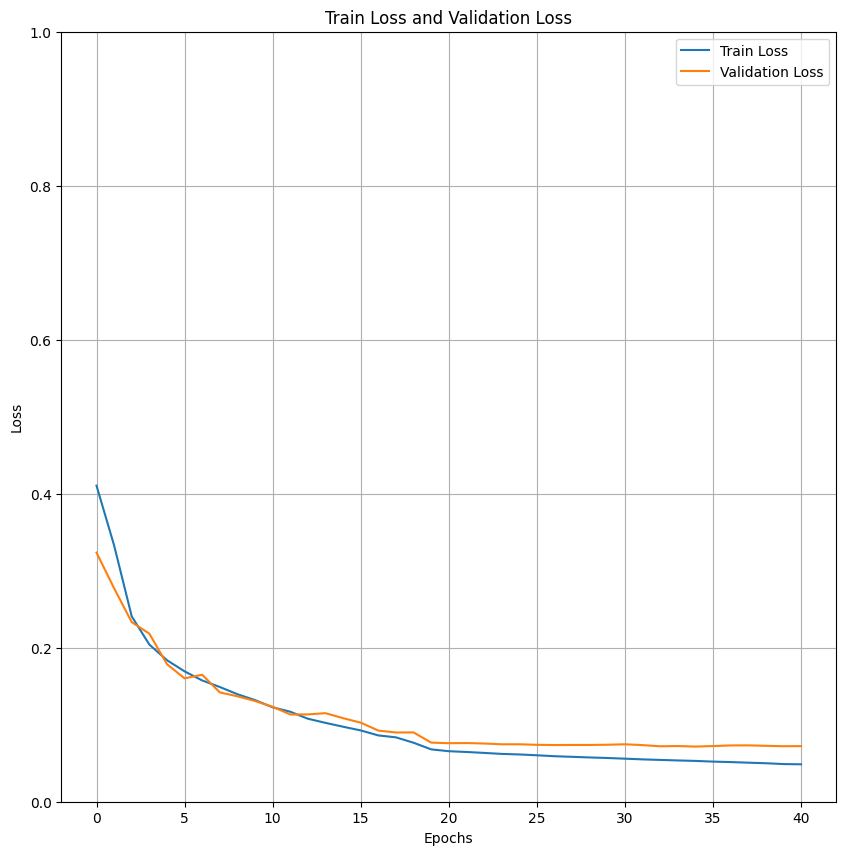

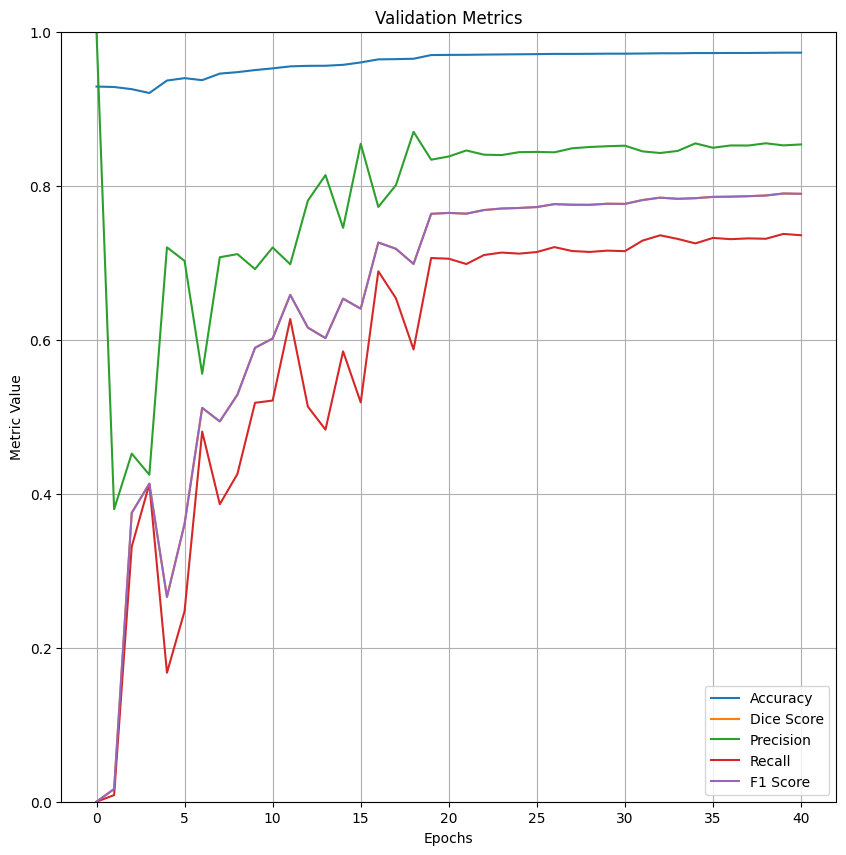

In [25]:


def read_metrics(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    metrics = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "accuracy": [],
        "dice_score": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    epoch = 0
    for line in lines:
        line = line.strip()
        if line.startswith("Train Loss:"):
            metrics["epoch"].append(epoch)
            metrics["train_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Validation Loss:"):
            metrics["val_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Accuracy:"):
            metrics["accuracy"].append(float(line.split(":")[1].strip())/100)
        elif line.startswith("Dice score:"):
            metrics["dice_score"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Precision:"):
            metrics["precision"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Recall:"):
            metrics["recall"].append(float(line.split(":")[1].strip()))
        elif line.startswith("F1 Score:"):
            metrics["f1_score"].append(float(line.split(":")[1].strip()))
            epoch += 1

    return metrics

def plot_metrics(metrics, save_dir=None):
    epochs = metrics["epoch"]

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "loss_plot.png"))
    else:
        plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["dice_score"], label="Dice Score")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.title("Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "metrics_plot.png"))
    else:
        plt.show()

metrics = read_metrics(model_dir + "/output/output.txt")
save_directory = model_dir + "/grafici"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
plot_metrics(metrics, save_dir=save_directory)


Test set

In [28]:
model1_path = "/content/drive/MyDrive/model4/best_model.pth.tar"
model2_path = "/content/drive/MyDrive/model8/best_model.pth.tar"
model3_path = "/content/drive/MyDrive/model10/best_model.pth.tar"

model1 = UNET(in_channels=4, out_channels=1).to(device)
model2 = UNET(in_channels=4, out_channels=1).to(device)
model3 = UNET(in_channels=4, out_channels=1).to(device)

load_checkpoint(torch.load(model1_path), model1)
load_checkpoint(torch.load(model2_path), model2)
load_checkpoint(torch.load(model3_path), model3)

criterion = nn.BCEWithLogitsLoss()


=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [38]:
test_transform = A.Compose([
    A.Resize(height=320, width=320),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

test_dataset = SARDataset(test_image_paths, test_label_paths, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


Uguale a eval_fn ma con aggiunta matrice di confusione

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_fn(loader, model, loss_fn, txtfile, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    total_dice_score = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x).squeeze(1)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            preds = torch.sigmoid(out)
            preds = (preds > 0.5).float()

            all_preds.append(preds.cpu().numpy().flatten())
            all_labels.append(y.cpu().numpy().flatten())

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            dice_score = (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            total_dice_score += dice_score.item()

            y_np = y.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            total_precision += precision_score(y_np, preds_np, zero_division=1)
            total_recall += recall_score(y_np, preds_np, zero_division=1)
            total_f1 += f1_score(y_np, preds_np, zero_division=1)

    avg_loss = total_loss / len(loader)
    avg_dice_score = total_dice_score / len(loader)
    avg_precision = total_precision / len(loader)
    avg_recall = total_recall / len(loader)
    avg_f1 = total_f1 / len(loader)
    accuracy = num_correct / num_pixels * 100

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Dice score: {avg_dice_score:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    with open(txtfile, "w") as f:
        f.write(f"Test Loss: {avg_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Dice score: {avg_dice_score:.4f}\n")
        f.write(f"Precision: {avg_precision:.4f}\n")
        f.write(f"Recall: {avg_recall:.4f}\n")
        f.write(f"F1 Score: {avg_f1:.4f}\n")

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(txtfile.replace(".txt", "_confusion_matrix.png"))

    model.train()
    return avg_loss, accuracy, avg_dice_score, avg_precision, avg_recall, avg_f1

In [33]:
test_txtfile1 = "/content/drive/MyDrive/test4/output.txt"
test_txtfile2 = "/content/drive/MyDrive/test8/output.txt"
test_txtfile3 = "/content/drive/MyDrive/test10/output.txt"

Test Loss: 0.0620
Accuracy: 97.99
Dice score: 0.8262
Precision: 0.8710
Recall: 0.7861
F1 Score: 0.8262


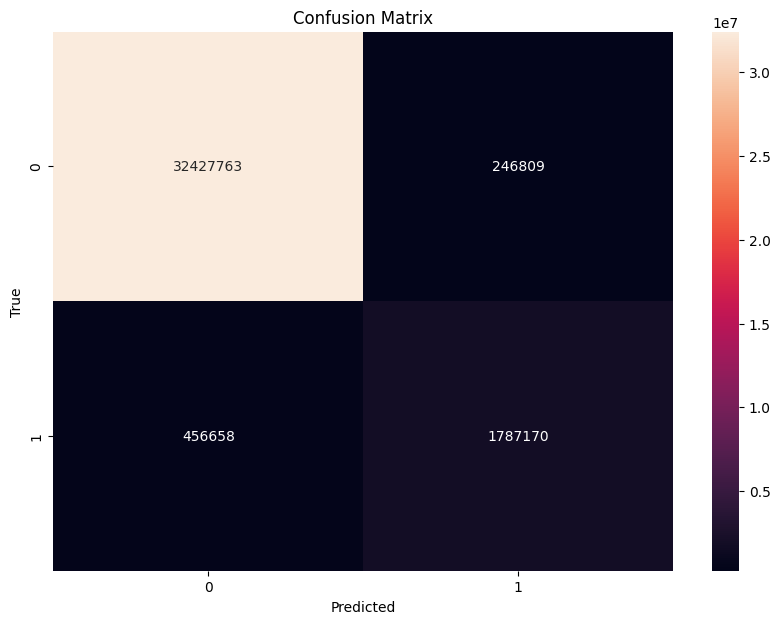

In [36]:
test_loss1, test_accuracy1, test_dice_score1, test_precision1, test_recall1, test_f1_1 = test_fn(test_loader, model1, criterion, test_txtfile1, device=device)

Test Loss: 0.0577
Accuracy: 98.00
Dice score: 0.8273
Precision: 0.8729
Recall: 0.7865
F1 Score: 0.8273


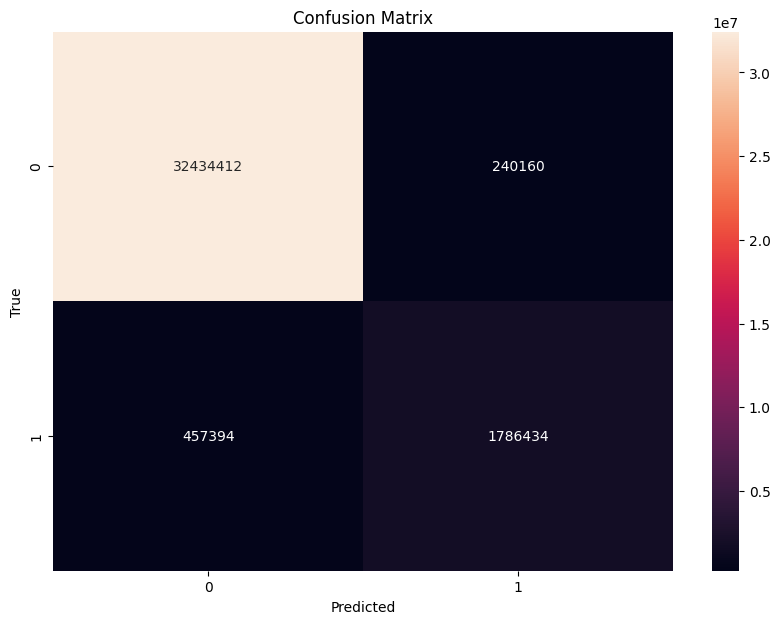

In [39]:
test_loss2, test_accuracy2, test_dice_score2, test_precision2, test_recall2, test_f1_2 = test_fn(test_loader, model2, criterion, test_txtfile2, device=device)

Test Loss: 0.0580
Accuracy: 98.02
Dice score: 0.8296
Precision: 0.8727
Recall: 0.7908
F1 Score: 0.8296


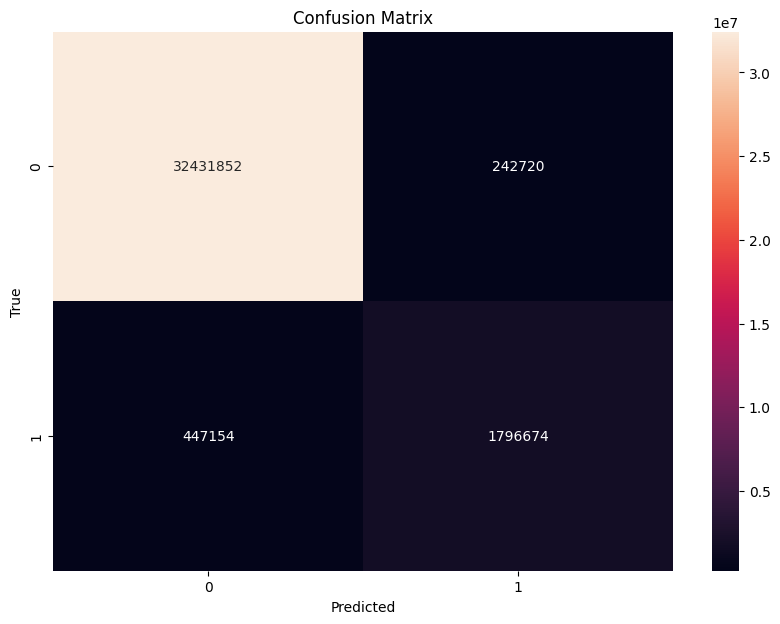

In [41]:
test_loss3, test_accuracy3, test_dice_score3, test_precision3, test_recall3, test_f1_3 = test_fn(test_loader, model3, criterion, test_txtfile3, device=device)